# Phenotypic Prediction in VEXAS vs. UBA1-WT vs. MDS patients

Steps described in this script:

#### 1. Test the consistency of the encoder's output

First, we test a similar pipeline (as described below) on images of leukocytes with known morphologic particularities.

1. <strong>Load data</strong>
1. <strong>Methods</strong>
1. <strong>Results</strong>

#### 2. Phenotypic prediction VEXAS / UBA1-WT / MDS

Perform binary classification VEXAS / UBA1-WT / MDS based on aggregated encodings and plot the prediction performance.

1. <strong>Load data</strong>
1. <strong>Methods</strong>
1. <strong>Results</strong>

First, we need to import all required libraries. Requirements are:
- matplotlib 3.3.4
- numpy 1.18.5
- pandas 1.1.5
- seaborn 0.11.2
- scikit-learn 0.24.1
- scipy 1.7.3
- tqdm 4.56.2
- umap-learn 0.5.3

In [1]:
# misc
import os
from tqdm import tqdm

# misc data manipulation
import pandas as pd
import numpy as np

# ML
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import umap

from scipy.stats import bootstrap

# visualization
import seaborn as sns
from matplotlib import pyplot as plt

SEED = 42 # seed used for ensuring reproducibility of random steps

We have to choose which leukocytes we'll use (either PMN, Lymphocytes or Monocytes).

In [2]:
CELLTYPES = ("PMN", "Lymphocytes", "Monocytes")

We'll declare the path used for retrieving data, according to the cell type:

In [3]:
WORKING_DIR = dict(PMN = "C:/VEXAS/out/PN",
                   Lymphocytes = "C:/VEXAS/out/LY",
                   Monocytes = "C:/VEXAS/out/MO",)

## 1. Test the consistency of the encoder's output

First, we will test the methodology on a small subset of cell images with known morphologic particularities, e.g. level of granulation and nucleus segmentation for PMN, presence of inclusions for monocytes and size and presence of granulations for lymphocytes.

### 1.1. Load data

We'll start by loading the encodings output by the neural network for our test images:

In [4]:
# we'll load encodings for each type of leukocyte
encodings = {CELLTYPE: np.load(os.path.join(WORKING_DIR[CELLTYPE], "encoder_test_encodings.npy")) for CELLTYPE in CELLTYPES}

And the associated metadata (i.e. the morphologic particularities of each cell image):

In [5]:
# as above, we'll load annotations for each type of leukocyte
metadata = {CELLTYPE: pd.read_csv(os.path.join(WORKING_DIR[CELLTYPE], "encoder_test_metadata.csv")) for CELLTYPE in CELLTYPES}
annotations = {CELLTYPE: metadata[CELLTYPE].GROUP.to_numpy() for CELLTYPE in CELLTYPES}

annotations

{'PMN': array(['LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG',
        'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG',
        'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG',
        'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG',
        'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG', 'LS-HG',
        'LS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG',
        'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG',
        'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG',
        'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG',
        'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG',
        'NS-HG', 'NS-HG', 'NS-HG', 'NS-HG', 'LS-LG', 'LS-LG', 'LS-LG',
        'LS-LG', 'LS-LG', 'LS-LG', 'LS-LG', 'LS-LG', 'LS-LG', 'LS-LG',
        'LS-LG', 'LS-LG', 'LS-LG', 'LS-LG', 'HS-LG', 'HS-LG', 'HS-LG',
        'HS-LG', 'HS-LG', 'HS-LG', 'HS-LG', 'HS-LG', 'HS-LG', 'HS-LG',

Annotations legend:

- For PMN: annotation according to the level of nucleus segmentation (low segmentation = 2 or less segments; high segmentation = 5 or more segments) and the level of granulation
    - LS-LG: Low segmentation - Low granulation
    - LS-NG: Low segmentation - Normal granulation
    - LS-HG: Low segmentation - High granulation
    - NS-NG: Normal segmentation - Normal granulation
    - NS-HG: Normal segmentation - High granulation
    - HS-LG: High segmentation - Low granulation
    - HS-NG: High segmentation - Normal granulation
    
    
- For lymphocytes:
    - SMALLMAT: small mature lymphocyte
    - LARGEGRAINS: large lymphocyte with granulations
    - LARGENOGRAINS: large lymphocyte without granulations
    - BLEBS: small mature lymphocyte with granulations


- For monocytes:
    - INCLUSIONS: with visible phagocytosis inclusions
    - NOINCLUSIONS: without visible phagocytosis inclusions

We should check that each encoding has exactly one annotation:

In [6]:
# check that encodings and metadata contain the same number of samples
for CELLTYPE in CELLTYPES:
    assert encodings[CELLTYPE].shape[0] == annotations[CELLTYPE].shape[0], "Inconsistent data"
# (this cell should return no error)

Before analyzing the encodings, they should be l2-normalized (i.e. the encodings of each cell image should sum up to 1)

In [7]:
# l2-normalize encodings
for CELLTYPE in CELLTYPES:
    encodings[CELLTYPE] = normalize(encodings[CELLTYPE], norm='l2', axis=1)

### 1.2. Methods

We will compare the leukocytes in a one-versus-one basis, each time comparing leukocytes in one group versus leukocytes of another group (e.g. high segmentation - low granulation PMN versus normal segmentation - normal granulation).

Our goal is thus to fill a matrix with columns = rows = possible groups, with each value being the mean classification ROC-AUC between the groups matching the row and column.

We will partition cells of the two compared groups in either a training set or a test set, by random stratified bootstrapping. This will be repeated 10 times, and mean ROC-AUC will be computed for each binary classification.

In [8]:
def EncoderTestClassification(CELLTYPE):

    # we list the groups that will be compared (one versus one), in the desired order
    if CELLTYPE == "PMN":
        groups = ('LS-LG', 'LS-NG', 'LS-HG', 'NS-NG', 'NS-HG', 'HS-LG', 'HS-NG')
    if CELLTYPE == "Lymphocytes":
        groups = ('SMALLMAT', 'BLEBS', 'LARGENOGRAINS', 'LARGEGRAINS')
    if CELLTYPE == "Monocytes":
        groups = ('NOINCLUSIONS', 'INCLUSIONS')

    # the results matrix, initially empty (i.e. filled with np.nan)
    test_results = np.empty( (len(groups),len(groups),) )
    test_results[:] = np.nan

    # for each possible combination group1 versus group2
    for groupi1 in range(len(groups)):
        for groupi2 in range(groupi1+1, len(groups)):
            # (with group1 different from group2 only)
            if groupi1 == groupi2:
                continue

            group1, group2 = groups[groupi1], groups[groupi2]

            # print('Comparing {} vs {}...'.format(group1, group2))

            # retrieve the encodings and annotations of samples in either group1 or group2
            filtered_encodings = encodings[CELLTYPE][np.isin(annotations[CELLTYPE], (group1,group2))]
            filtered_annotations = annotations[CELLTYPE][np.isin(annotations[CELLTYPE], (group1,group2))]
            # one hot encode annotations
            filtered_annotations_onehot = pd.get_dummies(filtered_annotations).loc[:,(group1,group2)].to_numpy()

            aucs = []

            # perform X times (i.e. X bootstraps)
            for n in range(ENCODERTEST_N_BOOTSTRAPS):
                # randomly partition samples in a training set and a test set
                # the partitioning is stratified in order to retain the same proportion of each group in both the training and the test sets
                train_encodings, test_encodings, train_annotations, test_annotations = train_test_split(filtered_encodings, filtered_annotations_onehot,
                                 train_size = .5,
                                 random_state = n,
                                 shuffle = True,
                                 stratify = filtered_annotations)

                # create a model and fit it on the training samples
                model = KNeighborsClassifier(n_neighbors=5)
                model.fit(train_encodings, train_annotations[:,1])

                # get model's predictions on the test set
                test_predictions = model.predict_proba(test_encodings)

                # compute AUC and store auc for all bootstraps
                auc = metrics.roc_auc_score(test_annotations[:,1], test_predictions[:,1])
                aucs.append(auc)

            # record the mean ROC-AUC for this binary comparison
            test_results[groupi1,groupi2] = np.mean(aucs)
            
    # compile results in a dataframe
    results_df = pd.DataFrame(test_results, columns=groups, index=groups)
    
    if results_df.shape[0] < 3: # if only 2 groups were compared, only 1 cell is needed for presenting results
        results_df = results_df.iloc[0:1,1:2]
    
    # with color formatting
    results_df = results_df.style.background_gradient(axis=None, cmap='RdYlGn')
    
    return results_df

We also define the number of bootstraps:

In [9]:
ENCODERTEST_N_BOOTSTRAPS = 10

In parallel of performing supervised classification, we'll also plot the test samples, after reducing the dimensions of the latent space via UMAP:

In [10]:
low_dimensional_encodings = {CELLTYPE: umap.UMAP(n_neighbors=5, random_state=SEED).fit_transform(encodings[CELLTYPE]) for CELLTYPE in CELLTYPES}

Below we declare the various graphics parameters used for plotting the figures:

In [11]:
# a mapping dictionary for converting abbreviated labels to human understandable labels
test_label_discrete_map = dict(PMN = {'LS-LG': 'Low seg./Low gran.',
                                      'LS-NG': 'Low seg./Normal gran.',
                                      'LS-HG': 'Low seg./High gran.',
                                      'NS-NG': 'Normal seg./Normal gran.',
                                      'NS-HG': 'Normal seg./High gran.',
                                      'HS-LG': 'High seg./Low gran.',
                                      'HS-NG': 'High seg./Normal gran.',},
                               Lymphocytes = {'SMALLMAT': 'Small - mature',
                                              'LARGEGRAINS': 'Large - granulations',
                                              'LARGENOGRAINS': 'Large - no granulations',
                                              'BLEBS': 'Blebs'},
                               Monocytes = {'INCLUSIONS': 'With inclusions',
                                            'NOINCLUSIONS': 'No inclusions'},)

# a mapping dictionary for coloring samples according to their group
test_color_discrete_map = dict(PMN = {'Low seg./Low gran.': '#8ecae6',
                                      'High seg./Low gran.': '#f4acb7',
                                      'Low seg./Normal gran.': '#118ab2',
                                      'Normal seg./Normal gran.': '#f48c06',
                                      'High seg./Normal gran.': '#ef476f',
                                      'Low seg./High gran.': '#003566',
                                      'Normal seg./High gran.': '#a44a3f',},
                               Lymphocytes = {'Small - mature': '#8ecae6',
                                              'Large - granulations': '#f48c06',
                                              'Large - no granulations': '#ef476f',
                                              'Blebs': '#003566'},
                               Monocytes = {'With inclusions': '#f48c06',
                                            'No inclusions': '#118ab2'},)

# a mapping dictionary for choosing the marker style of samples according to their group
test_marker_discrete_map = dict(PMN = {'Low seg./Low gran.': 'o',
                                       'High seg./Low gran.': 'o',
                                       'Low seg./Normal gran.': 'o',
                                       'Normal seg./Normal gran.': 'o',
                                       'High seg./Normal gran.': 'o',
                                       'Low seg./High gran.': 'o',
                                       'Normal seg./High gran.': 'o',},
                               Lymphocytes = {'Small - mature': 'o',
                                              'Large - granulations': 'o',
                                              'Large - no granulations': 'o',
                                              'Blebs': 'o'},
                               Monocytes = {'With inclusions': 'o',
                                            'No inclusions': 'o'},)

# a list for sorting the labels on the figure legend
labels_order = dict(PMN = ['Low seg./Low gran.',
                           'Low seg./Normal gran.',
                           'Low seg./High gran.',
                           'Normal seg./Normal gran.',
                           'Normal seg./High gran.',
                           'High seg./Low gran.',
                           'High seg./Normal gran.',],
                    Lymphocytes = ['Small - mature',
                                   'Blebs',
                                   'Large - no granulations',
                                   'Large - granulations'],
                    Monocytes = ['No inclusions',
                                 'With inclusions'])

And finally we define the function which will handle plotting:

In [12]:
def EncoderTestVisualization(CELLTYPE):

    # create a dataframe containing the low dimension encodings (i.e. after UMAP dimension reduction)
    plot_data = pd.DataFrame(low_dimensional_encodings[CELLTYPE])
    # rename columns (i.e. plot x and y-axes)
    plot_data.columns = ["UMAP{}".format(i+1) for i in range(plot_data.shape[1])]
    # add the annotation : i.e. the morphologic particularities of encodings' initial cell
    plot_data.loc[:,"Patient"] = [test_label_discrete_map[CELLTYPE][annot] for annot in annotations[CELLTYPE]]

    plt.figure(figsize=(10,6))
    sns.set(font_scale = 1.4)
    sns.set_style("whitegrid")
    sns.scatterplot(x='UMAP1', y='UMAP2',
                    data=plot_data,
                    hue='Patient',
                    style='Patient',
                    palette=test_color_discrete_map[CELLTYPE],
                    markers=test_marker_discrete_map[CELLTYPE],
                    legend=True,
                    s=100)

    handles_, labels_ = plt.gca().get_legend_handles_labels()
    # reorder labels
    new_label_order = [i2 for i1,l1 in enumerate(labels_order[CELLTYPE]) for i2,l2 in enumerate(labels_) if l1==l2]
    if len(labels_order[CELLTYPE]) > 4:
        LEGEND_N_COL = 3
    else:
        LEGEND_N_COL = 2
    plt.legend(bbox_to_anchor=(.5,-.15), handles=[handles_[jj] for jj in new_label_order], labels=[labels_[jj] for jj in new_label_order], title='Morphology', loc='upper center', ncol=LEGEND_N_COL, columnspacing=0.0)

    plt.tight_layout()
    plt.show()

### 1.3. Results

Finally, we can output the results for each cell type among PMN, lymphocytes and monocytes:

#### 1.3.1. Results for PMN:

In [13]:
EncoderTestClassification('PMN')

,LS-LG,LS-NG,LS-HG,NS-NG,NS-HG,HS-LG,HS-NG
LS-LG,nan,0.918651,1.000000,0.955714,1.000000,0.964935,0.967411
LS-NG,nan,nan,0.959568,0.916250,0.975731,0.994444,0.993750
LS-HG,nan,nan,nan,0.999167,0.833041,1.000000,1.000000
NS-NG,nan,nan,nan,nan,0.991842,0.840909,0.833974
NS-HG,nan,nan,nan,nan,nan,0.999761,0.999342
HS-LG,nan,nan,nan,nan,nan,nan,0.580398
HS-NG,nan,nan,nan,nan,nan,nan,nan


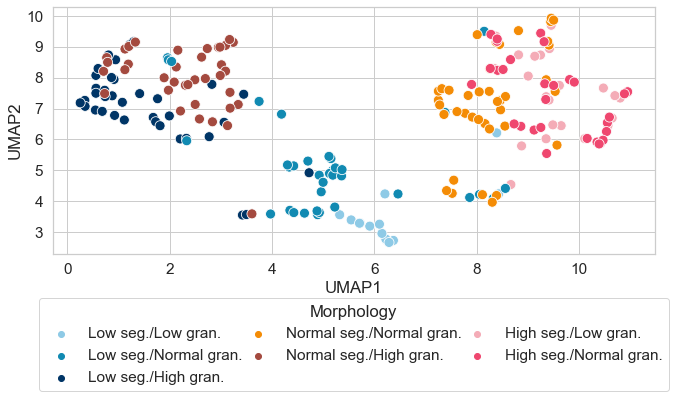

In [14]:
EncoderTestVisualization('PMN')

#### 1.3.2. Results for monocytes:

In [15]:
EncoderTestClassification('Monocytes')

,INCLUSIONS
NOINCLUSIONS,0.937111


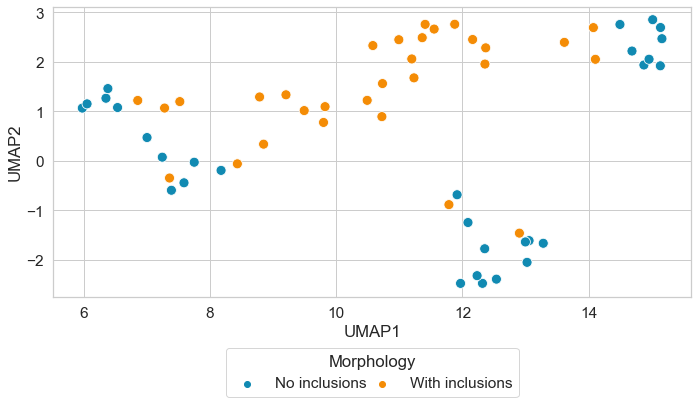

In [16]:
EncoderTestVisualization('Monocytes')

#### 1.3.3. Results for lymphocytes:

In [17]:
EncoderTestClassification('Lymphocytes')

,SMALLMAT,BLEBS,LARGENOGRAINS,LARGEGRAINS
SMALLMAT,nan,0.921111,0.996889,0.999778
BLEBS,nan,nan,0.982222,0.997556
LARGENOGRAINS,nan,nan,nan,0.882222
LARGEGRAINS,nan,nan,nan,nan


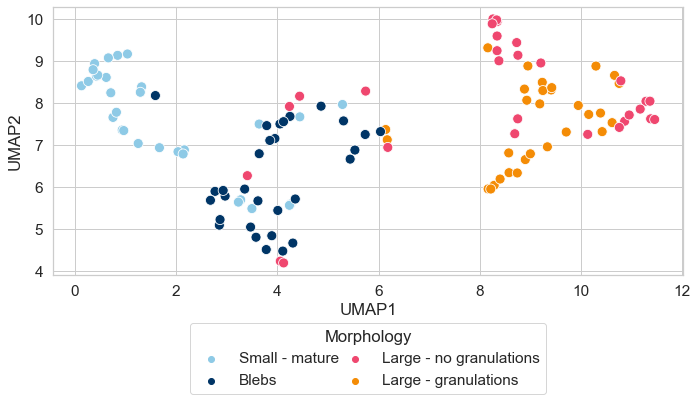

In [18]:
EncoderTestVisualization('Lymphocytes')

## 2. Phenotypic prediction VEXAS / UBA1-WT / MDS

Now that we have verified the consistency of our encoders' output, we can analyze VEXAS, UBA1-WT and MDS patients' encodings.

### 2.1. Load data

First, load metadata:

In [19]:
metadata = {CELLTYPE: pd.read_csv(os.path.join(WORKING_DIR[CELLTYPE], "metadata.csv")) for CELLTYPE in CELLTYPES}

In [20]:
metadata['PMN']

,PATIENT,SAMPLE,GROUP
0,VEXAS[1],SV1ad7dN,VEXAS
1,VEXAS[1],SV1ad7dN,VEXAS
2,VEXAS[1],SV1ad7dN,VEXAS
3,VEXAS[1],SV1ad7dN,VEXAS
4,VEXAS[1],SV1ad7dN,VEXAS
...,...,...,...
19270,UBA1-WT[3],CiSNQpsG,UBA1-WT
19271,UBA1-WT[3],CiSNQpsG,UBA1-WT
19272,UBA1-WT[3],CiSNQpsG,UBA1-WT
19273,UBA1-WT[3],CiSNQpsG,UBA1-WT


In [21]:
metadata['Lymphocytes']

,PATIENT,SAMPLE,GROUP
0,VEXAS[1],SV1ad7dN,VEXAS
1,VEXAS[1],SV1ad7dN,VEXAS
2,VEXAS[1],SV1ad7dN,VEXAS
3,VEXAS[1],SV1ad7dN,VEXAS
4,VEXAS[1],SV1ad7dN,VEXAS
...,...,...,...
11480,UBA1-WT[3],CiSNQpsG,UBA1-WT
11481,UBA1-WT[3],CiSNQpsG,UBA1-WT
11482,UBA1-WT[3],CiSNQpsG,UBA1-WT
11483,UBA1-WT[3],CiSNQpsG,UBA1-WT


In [22]:
metadata['Monocytes']

,PATIENT,SAMPLE,GROUP
0,VEXAS[1],SV1ad7dN,VEXAS
1,VEXAS[1],SV1ad7dN,VEXAS
2,VEXAS[1],SV1ad7dN,VEXAS
3,VEXAS[1],SV1ad7dN,VEXAS
4,VEXAS[1],SV1ad7dN,VEXAS
...,...,...,...
2992,UBA1-WT[3],Xd8gfbBe,UBA1-WT
2993,UBA1-WT[3],Xd8gfbBe,UBA1-WT
2994,UBA1-WT[3],Xd8gfbBe,UBA1-WT
2995,UBA1-WT[3],Xd8gfbBe,UBA1-WT


And retrieve metadata for each encoding for further analysis (cell encodings' owner, sample and disease):

In [23]:
# convert to numpy array so manipulation will be easier
Y_patient = {CELLTYPE: np.array(metadata[CELLTYPE].PATIENT) for CELLTYPE in CELLTYPES}
Y_sample = {CELLTYPE: np.array(metadata[CELLTYPE].SAMPLE) for CELLTYPE in CELLTYPES}
Y_group = {CELLTYPE: np.array(metadata[CELLTYPE].GROUP) for CELLTYPE in CELLTYPES}

Second, load cell images encodings:

In [24]:
encodings = {CELLTYPE: np.load(os.path.join(WORKING_DIR[CELLTYPE], "encodings.npy")) for CELLTYPE in CELLTYPES}

We should have 1 metadata for each encoding, exactly:

In [25]:
for CELLTYPE in CELLTYPES:
    assert encodings[CELLTYPE].shape[0] == metadata[CELLTYPE].shape[0], "Inconsistent data"

L2-normalize encodings, so each cell encodings sum to 1:

In [26]:
# scale encodings
for CELLTYPE in CELLTYPES:
    encodings[CELLTYPE] = normalize(encodings[CELLTYPE], norm='l2', axis=1)

### 2.2. Methods

We'll declare the `getAggregatedEncodingsForPatients` function, which creates `number_aggregates` of size `size_of_aggregates` for each unique patient identified in the `patients` argument. Each median (i.e. aggregated) encoding will be matched with an annotation, either the patient whose image encodings belong or this patient's pathology, according to the `which_annotation` value. This function is also passed a random number generator (`numpy.random.RandomState` object) in order to retain reproducibility.

In [27]:
def getAggregatedEncodingsForPatients(CELLTYPE, patients, number_aggregates, size_of_aggregates, which_annotation, rng):
    aggreg_encodings, aggreg_annotations = [], []
    for patient in patients:
        for i in range(number_aggregates):
            # make bootstraps of cells for each patient
            # get the sample indices for this patient's bootstrap
            bootstrap_indices = rng.choice(np.where(Y_patient[CELLTYPE]==patient)[0], size=size_of_aggregates)
            # get the annotation (i.e. patient's ID)
            if which_annotation == "patient":
                bootstrap_annotation = Y_patient[CELLTYPE][bootstrap_indices[0]]
            if which_annotation == "group":
                bootstrap_annotation = Y_group[CELLTYPE][bootstrap_indices[0]]
            # get the encodings according to the bootstrap indices
            bootstrap_encodings = encodings[CELLTYPE][bootstrap_indices,...]
            # aggregate encodings by computing median
            bootstrap_encodings = np.median(bootstrap_encodings, axis=0).reshape(1,-1)
            # store retrieved data
            aggreg_encodings.append(bootstrap_encodings)
            aggreg_annotations.append(bootstrap_annotation)
        
    # convert from list to np array
    aggreg_encodings = np.concatenate(aggreg_encodings)
    aggreg_annotations = np.array(aggreg_annotations)
    
    return aggreg_encodings, aggreg_annotations

We call the `getAggregatedEncodingsForPatients` function to create 100 bootstraps for each patient (regardless patient's pathology). We fetch as the annotation the name of each patient in order to visualize differences between each patient, rather than simply differences between patients with the same pathology.

This time, we'll only compare patients' cell encodings by pathology, each time one versus one (e.g. VEXAS vs UBA1-WT, without MDS patients). For each binary comparison:
- We'll train a SVM model on one half of the patients and test it on the other half. As we did previously, the model won't be trained on raw encodings but on aggregated encodings. The model will be trained N times, each time with a different, random partitioning (i.e. not trained/tested on the same patients);
- We'll visualize the repartition of all aggregated encodings in the latent space, without any partitioning.

First, we need to declare the parameters used for this step. Those are:
- `BOOTSTRAP_SEED`: the random seed used for reproducibility
- `BOOTSTRAP_ITERATIONS`: the number of bootstrap iterations, i.e. the number of times patients will be partitioned randomly and the model will be trained and tested on different aggregates of encodings
- `BOOTSTRAP_TRAINPART`: the percentage of patients to include in the training set for each bootstrap


- `N_AGGREGATES`, the number of aggregates, i.e. bootstraps of encodings used for each patient
- `SIZE_OF_AGGREGATES`, the size of aggregates, i.e. the number of encodings that should be included in each aggregate, for computing median encodings


- `THRESHOLD`: threshold used for computing sensitivity and specificity based on the SVM model output ([0-1])

In [28]:
BOOTSTRAP_SEED = 4512
BOOTSTRAP_ITERATIONS = 10
BOOTSTRAP_TRAINPART = .50

N_AGGREGATES = 100
SIZE_OF_AGGREGATES = 10

THRESHOLD = 0.5

Below is the `partitionPatientsInTrainTest` function, which we'll use for randomly partitinoning patients into either the training or the test set.

This function allows performing stratified partitioning, ensuring that for each of the two pathologies considered (e.g. VEXAS and UBA1-WT), half of the patients with this specific pathology are effectively placed in the training set, and the other half in the test set.

In [29]:
def partitionPatientsInTrainTest(CELLTYPE, groups, seed):
    # prepare bootstrap data
    # we construct a dataframe with patients' name & group
    partition_df = pd.DataFrame(dict(PATIENT=Y_patient[CELLTYPE],GROUP=Y_group[CELLTYPE]))
    # we drop the duplicates, so we only have 1 line per patient
    partition_df = partition_df.drop_duplicates()
    # we keep only patients belonging to one of the groups we're analyzing (e.g. VEXAS vs MDS)
    partition_df = partition_df.loc[partition_df.GROUP.isin(groups),:]
    # we extracted the ordered list of patients and their group
    patients_id_list = partition_df.PATIENT.to_list()
    patients_group_list = partition_df.GROUP.to_list()
    # we perform the bootstrap
    # we use the resample function allowing to perform a stratified partitioning
    patients_in_train_bootstrap = resample(patients_id_list, replace=False, n_samples=len(patients_id_list)*BOOTSTRAP_TRAINPART, random_state=seed, stratify=patients_group_list)
    # patients excluded from training set are placed into the test set
    patients_in_test_bootstrap = np.setdiff1d(patients_id_list, patients_in_train_bootstrap)
    # return
    return patients_in_train_bootstrap, patients_in_test_bootstrap

The `bootstrapTrainTest` function below takes as input an untrained model (e.g. SVM) a couple of groups (i.e. pathologies, e.g. VEXAS and UBA1-WT) and performs the following:
- Call the `partitionPatientsInTrainTest` function to partition patients into training/test set
- Call the `getAggregatedEncodingsForPatients` function declared earlier to create aggregated encodings for each patient, along with their annotations
- Train the model on the training set, test it on the test set and compute test AUC, sensitivity (Se) and specificity (Sp)

In [30]:
def bootstrapTrainTest(CELLTYPE, model, groups, seed):
    # get patient bootstraps
    patients_in_train_bootstrap, patients_in_test_bootstrap = partitionPatientsInTrainTest(CELLTYPE, groups, seed)

    rng = np.random.RandomState(seed)
    
    train_encodings, train_annotations = getAggregatedEncodingsForPatients(CELLTYPE,
                                                                           patients = patients_in_train_bootstrap,
                                                                           number_aggregates = N_AGGREGATES,
                                                                           size_of_aggregates = SIZE_OF_AGGREGATES,
                                                                           which_annotation = "group",
                                                                           rng=rng)
    test_encodings, test_annotations = getAggregatedEncodingsForPatients(CELLTYPE,
                                                                         patients = patients_in_test_bootstrap,
                                                                         number_aggregates = N_AGGREGATES,
                                                                         size_of_aggregates = SIZE_OF_AGGREGATES,
                                                                         which_annotation = "group",
                                                                         rng=rng)
    
    # before training/testing the model, we have to one hot encode the annotations
    train_annotations = pd.get_dummies(train_annotations).loc[:, groups].to_numpy()
    test_annotations = pd.get_dummies(test_annotations).loc[:, groups].to_numpy()
    
    # train_annotations and test_annotations are one hot encoded matrices
    # we always only consider the last column when training/testing the model (i.e. the last group)
    # thus, when comparing only 2 groups, the second group is considered 'positive' and the first 'negative'
    # when comparing all three groups, the last (third) group is considered 'positive' versus both first and second groups, thus considered both 'negatives'
    
    # fit our SVM model on train samples
    model.fit(train_encodings, train_annotations[:,-1])

    test_predictions = model.predict_proba(test_encodings)
    
    # determine auc
    auc = metrics.roc_auc_score(test_annotations[:,-1], test_predictions[:,-1])
    
    # determine test se/sp at chosen threshold
    # determine number of true positives, true negatives, false positives, false negatives
    tp = np.sum(np.logical_and(test_annotations[:,-1] >= .5, test_predictions[:,-1] >= THRESHOLD))
    fp = np.sum(np.logical_and(test_annotations[:,-1] < .5,  test_predictions[:,-1] >= THRESHOLD))
    tn = np.sum(np.logical_and(test_annotations[:,-1] < .5,  test_predictions[:,-1] < THRESHOLD))
    fn = np.sum(np.logical_and(test_annotations[:,-1] >= .5, test_predictions[:,-1] < THRESHOLD))
    
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    
    return auc, se, sp

Finally, the `PhenotypicPrediction` function takes as input a couple of groups (e.g. pathologies) and performs the following:
- Call the `bootstrapTrainTest` 10 times in order to compute the mean AUC, Se and Sp over 10 random bootstraps
- Plot the repartition of cell encodings for the patients with the considered pathologies / in the considered groups along with picturing the supervised prediction results (mean and 95%-confidence interval AUC, Se, Sp)

In [31]:
# for METHOD in ("regular","bootstraps_med"):
def PhenotypicPrediction(CELLTYPE, groups, legend=True, return_plot=False):
    model=SVC(C=1., kernel='rbf', probability=True)

    aucs = []
    ses = []
    sps = []

    for n in tqdm(range(BOOTSTRAP_ITERATIONS)):
        # select bootstrap
        auc, se, sp = bootstrapTrainTest(CELLTYPE=CELLTYPE, model=model, groups=groups, seed=BOOTSTRAP_SEED+n)
        aucs.append(auc)
        ses.append(se)
        sps.append(sp)

    # compute results : mean and 95%IC boundaries for AUC, Se and Sp
    auc_res = bootstrap([aucs,], np.mean, confidence_level=.95).confidence_interval
    se_res = bootstrap([ses,], np.mean, confidence_level=.95).confidence_interval
    sp_res = bootstrap([sps,], np.mean, confidence_level=.95).confidence_interval
    res = dict(auc=dict(mean=np.mean(aucs),low=auc_res.low,high=auc_res.high),
               se=dict(mean=np.mean(ses),low=se_res.low,high=se_res.high),
               sp=dict(mean=np.mean(sps),low=sp_res.low,high=sp_res.high),)

    # get aggregated encodings for all patients (without partitioning) for visualization
    aggreg_encodings, aggreg_annotations = getAggregatedEncodingsForPatients(CELLTYPE = CELLTYPE,
                                                                             patients = np.unique(Y_patient[CELLTYPE][np.isin(Y_group[CELLTYPE], groups)]),
                                                                             number_aggregates = N_AGGREGATES,
                                                                             size_of_aggregates = SIZE_OF_AGGREGATES,
                                                                             which_annotation = "patient",
                                                                             rng = np.random.RandomState(seed=BOOTSTRAP_SEED))

    # apply umap on encodings
    plot_data_material = umap.UMAP(random_state = SEED).fit_transform(aggreg_encodings)
    
    plot_data = pd.DataFrame(plot_data_material)
    pcnames = ['UMAP1','UMAP2']
    plot_data.columns = ["UMAP{}".format(i+1) for i in range(plot_data.shape[1])]
    plot_data["Patient"] = aggreg_annotations
    if legend:
        f = plt.figure(figsize=(8,4))
    else:
        f = plt.figure(figsize=(6,4))
    sns.set(font_scale = 1.0)
    sns.set_style("whitegrid")
    sns.scatterplot(x=pcnames[0], y=pcnames[1],
                    data=plot_data,
                    hue='Patient',
                    style='Patient',
                    palette=color_discrete_map,
                    markers=marker_discrete_map,
                    s=100,
                    legend=legend)

    classify_text = """Mean ROC-AUC: {mean_auc:.2f} [{lo_auc:.2f}-{hi_auc:.2f}]
Mean sensitivity: {mean_se:.1f}% [{lo_se:.1f}-{hi_se:.1f}]
Mean specificity: {mean_sp:.1f}% [{lo_sp:.1f}-{hi_sp:.1f}]""".format(mean_auc=res['auc']['mean'],lo_auc=res['auc']['low'],hi_auc=res['auc']['high'],
                                                         mean_se=100*res['se']['mean'],lo_se=100*res['se']['low'],hi_se=100*res['se']['high'],
                                                         mean_sp=100*res['sp']['mean'],lo_sp=100*res['sp']['low'],hi_sp=100*res['sp']['high'])

    text_x_pos = plot_data.loc[:,pcnames[0]].min() + (plot_data.loc[:,pcnames[0]].max()-plot_data.loc[:,pcnames[0]].min())/4.0
    text_y_pos = plot_data.loc[:,pcnames[1]].min()
    verticalalignment='bottom'
    horizontalalignment='left'

    plt.text(text_x_pos, text_y_pos, classify_text,
             fontsize=12,
             verticalalignment=verticalalignment,
             horizontalalignment=horizontalalignment,
             bbox=dict(boxstyle='round',
                       facecolor='white',
                       edgecolor='#909090',
                       alpha=0.5),
             linespacing = 2)
    
    if legend:
        handles_, labels_ = plt.gca().get_legend_handles_labels()
        # reorder labels
        new_label_order = np.argsort(labels_).tolist()
        plt.legend(bbox_to_anchor=(1.04,.5), handles=[handles_[jj] for jj in new_label_order], labels=[labels_[jj] for jj in new_label_order], title='Patient', loc='center left')
    
    # reminder :
    # train_annotations and test_annotations are one hot encoded matrices
    # we always only consider the last column when training/testing the model (i.e. the last group)
    # thus, when comparing only 2 groups, the second group is considered 'positive' and the first 'negative'
    # when comparing all three groups, the last (third) group is considered 'positive' versus both first and second groups, thus considered both 'negatives'
    if len(groups) == 3:
        plt.title("Phenotypic prediction {} vs. other groups [{}]".format(groups[2], CELLTYPE))
    elif len(groups) == 2:
        plt.title("Phenotypic prediction {} vs. {} [{}]".format(groups[1], groups[0], CELLTYPE))
    
    plt.tight_layout()
    
    if return_plot:
        return(f)
    return None

And we declare various parameters used for plotting figure (e.g. point color according to the patient's pathology)

In [32]:
# assign a color/marker to each patient in our cohort
color_discrete_map = {'VEXAS[1]': '#f28482',
                      'VEXAS[2]': '#f28482',
                      'VEXAS[3]': '#f28482',
                      'UBA1-WT[1]': '#84a59d',
                      'UBA1-WT[2]': '#84a59d',
                      'UBA1-WT[3]': '#84a59d',
                      'MDS[1]': '#ffd166',
                      'MDS[2]': '#ffd166',
                      'MDS[3]': '#ffd166',
                      'MDS[4]': '#ffd166',
                      'MDS[5]': '#ffd166',
                      'MDS[6]': '#ffd166',}
marker_discrete_map = {'VEXAS[1]': 'X',
                       'VEXAS[2]': 's',
                       'VEXAS[3]': 'o',
                       'UBA1-WT[1]': 'X',
                       'UBA1-WT[2]': 's',
                       'UBA1-WT[3]': 'o',
                       'MDS[1]': 'X',
                       'MDS[2]': 's',
                       'MDS[3]': 'o',
                       'MDS[4]': '^',
                       'MDS[5]': 'P',
                       'MDS[6]': 'v',}

### 2.3. Results

We can then call our function for, respectively for discriminating: UBA1-WT vs. VEXAS, MDS vs. VEXAS and MDS vs. UBA1-WT:

#### 2.3.1. PMN

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


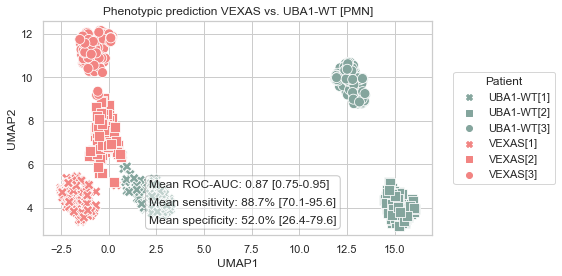

In [33]:
PhenotypicPrediction('PMN', groups = ('UBA1-WT', 'VEXAS'))

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


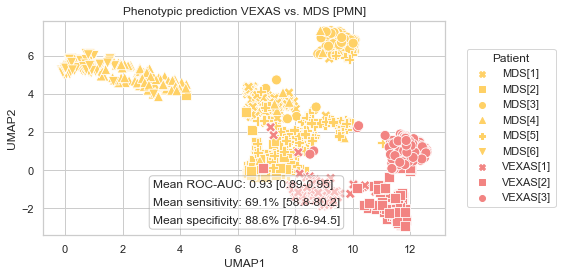

In [34]:
PhenotypicPrediction('PMN', groups = ('MDS', 'VEXAS'))

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


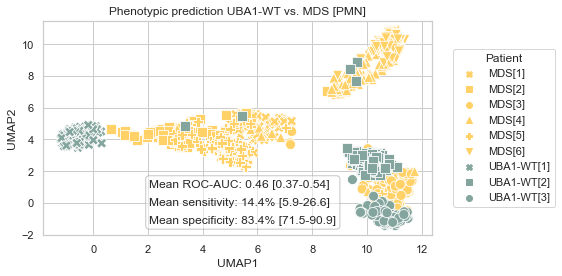

In [35]:
PhenotypicPrediction('PMN', groups = ('MDS', 'UBA1-WT'))

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


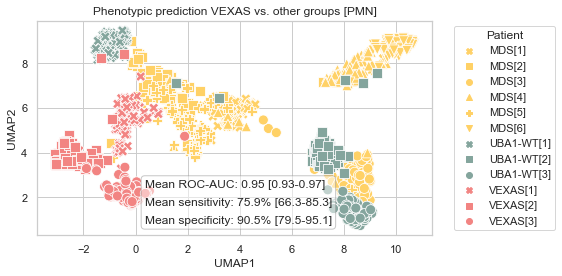

In [36]:
PhenotypicPrediction('PMN', groups = ('MDS', 'UBA1-WT', 'VEXAS'))

#### 2.3.2. Monocytes

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


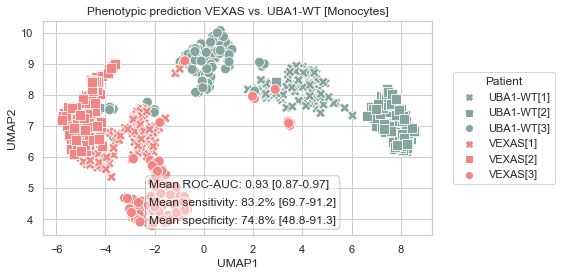

In [37]:
PhenotypicPrediction('Monocytes', groups = ('UBA1-WT', 'VEXAS'))

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


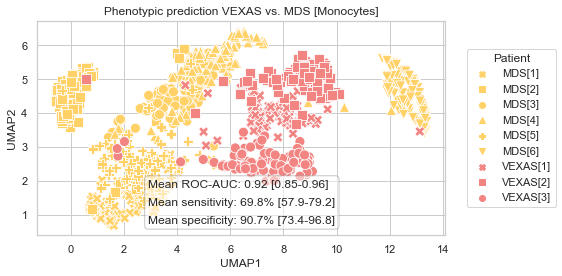

In [38]:
PhenotypicPrediction('Monocytes', groups = ('MDS', 'VEXAS'))

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


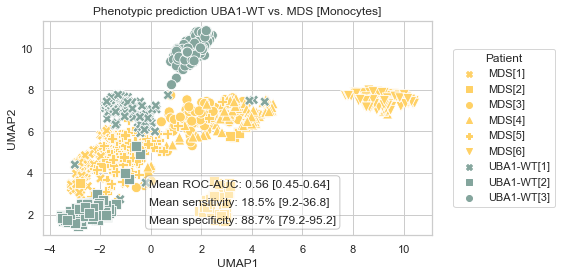

In [39]:
PhenotypicPrediction('Monocytes', groups = ('MDS', 'UBA1-WT'))

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


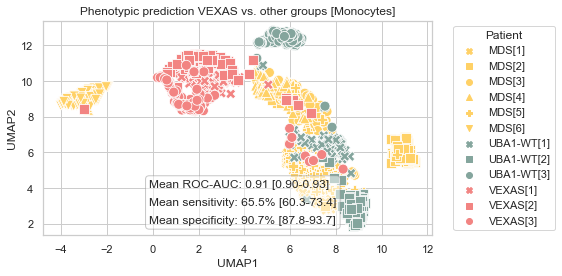

In [40]:
PhenotypicPrediction('Monocytes', groups = ('MDS', 'UBA1-WT', 'VEXAS'))

#### 2.3.3. Lymphocytes

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


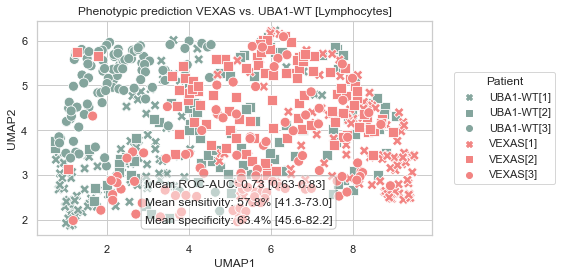

In [41]:
PhenotypicPrediction('Lymphocytes', groups = ('UBA1-WT', 'VEXAS'))

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


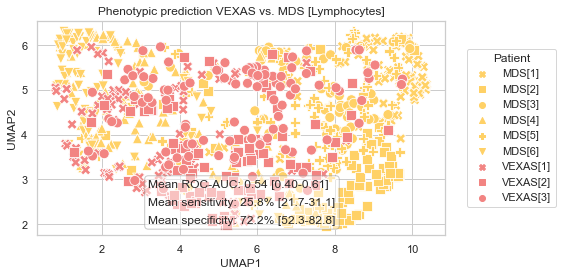

In [42]:
PhenotypicPrediction('Lymphocytes', groups = ('MDS', 'VEXAS'))

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


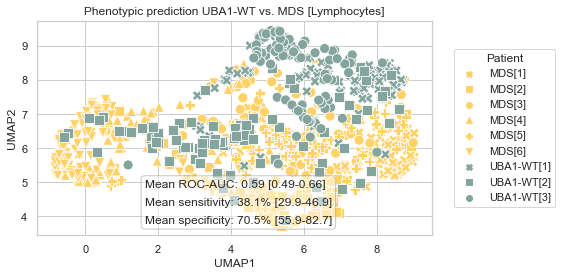

In [43]:
PhenotypicPrediction('Lymphocytes', groups = ('MDS', 'UBA1-WT'))

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


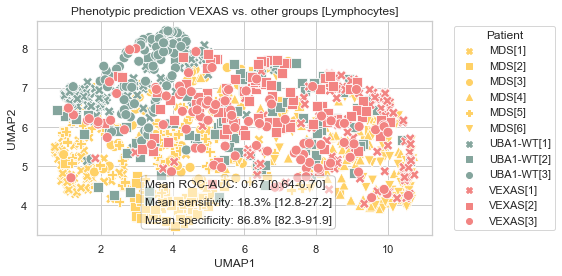

In [44]:
PhenotypicPrediction('Lymphocytes', groups = ('MDS', 'UBA1-WT', 'VEXAS'))